t=0: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=9.20, Js=0.91, Ji=2.44
t=1: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=2.10, Js=0.21, Ji=0.73
t=2: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=0.53, Js=0.05, Ji=0.28
t=3: y=0.50, s=0.05, ui=[0.05, 0.05, 0.05], Jp=0.09, Js=0.10, Ji=0.14
t=4: y=0.10, s=0.20, ui=[0.05, 0.05, 0.27], Jp=0.04, Js=0.01, Ji=0.15
t=5: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=0.06, Js=0.01, Ji=0.08
t=6: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=0.04, Js=0.00, Ji=0.04
t=7: y=0.10, s=0.20, ui=[0.05, 0.05, 0.27], Jp=0.01, Js=0.00, Ji=0.03
t=8: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=0.01, Js=0.00, Ji=0.02
t=9: y=0.10, s=0.05, ui=[0.05, 0.05, 0.05], Jp=0.01, Js=0.00, Ji=0.01


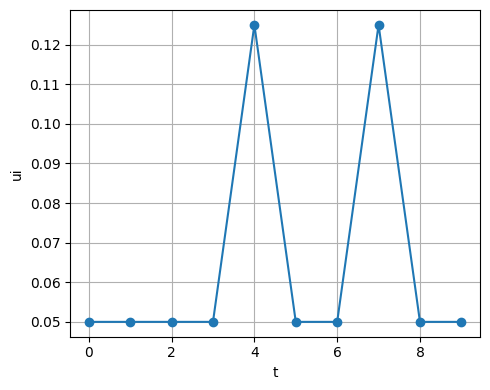

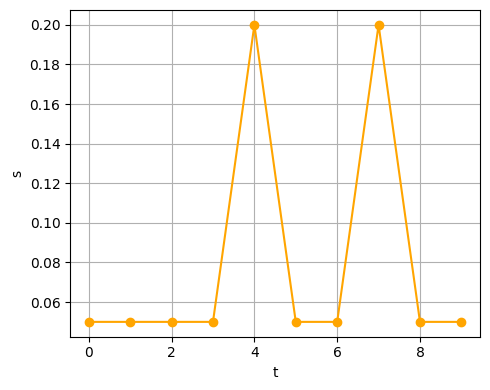

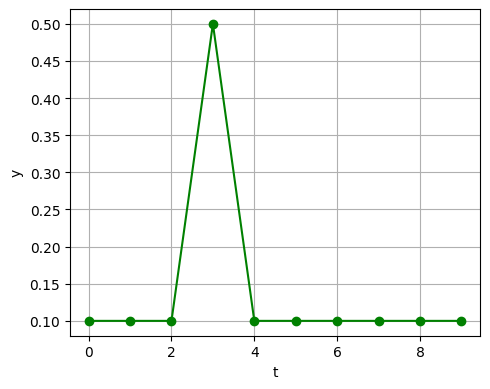

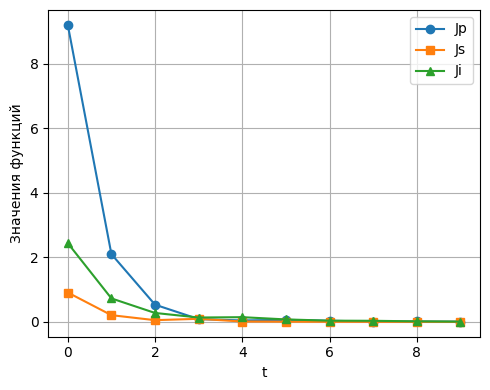

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

class Agent:
    def __init__(self, initial_resources, depreciation, agent_id, phi_coef=0.5):
        self.resources = initial_resources
        self.depreciation = depreciation
        self.ui = 0
        self.vi = 0
        self.pi_coef = 0.0025
        self.si = 0
        self.id = agent_id
        self.phi_coef = phi_coef

    def allocate_resources(self, ui_ratio):
        self.ui = self.resources * ui_ratio
        self.vi = self.resources * 0.1

    def update_resources(self, supervisor_support):
        self.resources = (1 - self.depreciation) * self.resources + self.vi + supervisor_support

    def produce_public_good(self):
        return self.phi_coef * np.sqrt(self.ui)

class Supervisor:
    def __init__(self, total_resources, M):
        self.total_resources = total_resources
        self.M = M
        self.allocated_resources = {}

    def allocate_resources(self, agents, s_value):
        per_agent = s_value * self.total_resources
        for agent in agents:
            self.allocated_resources[agent] = per_agent

    def get_support(self, agent):
        return self.allocated_resources.get(agent, 0)

class Principal:
    def __init__(self, y, z):
        self.y = y
        self.z = z

def c(x):
    return np.sqrt(x)

def C(z):
    return 0.5 * z**2

def compute_Jp(y, s_list, x, z, rho, t):
    return np.exp(-rho * t) * ((1 - y - sum(s_list)) * c(x) - C(z))

def compute_Js(y, z, x, rho, t, M):
    Mz = M * z
    return np.exp(-rho * t) * ((1 - z - Mz) * y * c(x))

def compute_Ji(agent, x, rho, t):
    return np.exp(-rho * t) * (
        agent.pi_coef * (agent.resources - agent.ui - agent.vi) +
        agent.si * c(x)
    )

def simulate(params):
    agents = [
        Agent(
            initial_resources=params["agent_params"][i]["initial_resources"],
            depreciation=params["agent_params"][i]["depreciation"],
            agent_id=i,
            phi_coef=params["agent_params"][i]["phi_coef"]
        )
        for i in range(params["num_agents"])
    ]
    supervisor = Supervisor(params["supervisor_resources"], params["M"])
    principal = Principal(y=0.1, z=params["z"])

    history = {
        "x": [params["x0"]],
        "optimal_params": [],
        "Jp": [], "Js": [], "Ji": [],
        "resources": [[] for _ in agents],
        "ui": [[] for _ in agents],
        "Mz": []
    }

    for t in range(params["timesteps"]):
        best_combo = None
        best_value = -np.inf

        for y in np.linspace(0.1, 0.9, 5):
            principal.y = y
            best_js = -np.inf
            best_s = 0
            best_ui_set = []
            best_x = 0
            best_ji = 0

            for s in np.linspace(0.05, 0.2, 3):
                if y + s * len(agents) > 1:
                    continue
                supervisor.allocate_resources(agents, s)
                for agent in agents:
                    agent.si = s

                ui_set = []
                for agent in agents:
                    best_ui = 0
                    best_Ji = -np.inf
                    for ui_ratio in np.linspace(params["ui_bounds"][0], params["ui_bounds"][1], 5):
                        agent.allocate_resources(ui_ratio)
                        x_tmp = (1 - params["mu"]) * history["x"][-1] + sum(
                            ag.produce_public_good() if ag.id != agent.id else agent.produce_public_good()
                            for ag in agents)
                        Ji = compute_Ji(agent, x_tmp, params["rho"], t)
                        if Ji > best_Ji:
                            best_Ji = Ji
                            best_ui = ui_ratio
                    agent.allocate_resources(best_ui)
                    ui_set.append(best_ui)

                for i, agent in enumerate(agents):
                    agent.allocate_resources(ui_set[i])

                x_now = (1 - params["mu"]) * history["x"][-1] + sum(agent.produce_public_good() for agent in agents)
                Js = compute_Js(y, params["z"], x_now, params["rho"], t, supervisor.M)
                if Js > best_js:
                    best_js = Js
                    best_s = s
                    best_ui_set = ui_set
                    best_x = x_now
                    best_ji = sum(compute_Ji(agent, x_now, params["rho"], t) for agent in agents)

            s_list = [best_s] * len(agents)
            Jp = compute_Jp(y, s_list, best_x, params["z"], params["rho"], t)
            if Jp > best_value:
                best_value = Jp
                best_combo = {
                    "y": y,
                    "s": best_s,
                    "ui": best_ui_set,
                    "Jp": Jp,
                    "Js": best_js,
                    "Ji": best_ji,
                    "x": best_x
                }

        print(f"t={t}: y={best_combo['y']:.2f}, s={best_combo['s']:.2f}, ui={[float(round(u, 2)) for u in best_combo['ui']]}, "
              f"Jp={best_combo['Jp']:.2f}, Js={best_combo['Js']:.2f}, Ji={best_combo['Ji']:.2f}")

        supervisor.allocate_resources(agents, best_combo["s"])
        principal.y = best_combo["y"]

        for i, agent in enumerate(agents):
            agent.allocate_resources(best_combo["ui"][i])
            agent.update_resources(supervisor.get_support(agent))
            history["resources"][i].append(agent.resources)
            history["ui"][i].append(best_combo["ui"][i])

        history["x"].append(best_combo["x"])
        history["Mz"].append(supervisor.M * principal.z)
        history["optimal_params"].append({
            "t": t, "y": best_combo["y"], "s": best_combo["s"], "ui": best_combo["ui"],
            "Jp": best_combo["Jp"], "Js": best_combo["Js"], "Ji": best_combo["Ji"]
        })
        history["Jp"].append(best_combo["Jp"])
        history["Js"].append(best_combo["Js"])
        history["Ji"].append(best_combo["Ji"])

    return history

def plot_individual_graphs(history):
    timesteps = list(range(len(history["optimal_params"])))

    # 1. График среднего ui по времени
    avg_ui_per_timestep = [
        np.mean(step["ui"]) for step in history["optimal_params"]
    ]
    plt.figure(figsize=(5, 4))
    plt.plot(timesteps, avg_ui_per_timestep, marker='o')
    plt.title("")
    plt.xlabel("t")
    plt.ylabel("ui")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. График s по времени
    s_values = [step["s"] for step in history["optimal_params"]]
    plt.figure(figsize=(5, 4))
    plt.plot(timesteps, s_values, marker='o', color='orange')
    plt.title("")
    plt.xlabel("t")
    plt.ylabel("s")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. График y по времени
    y_values = [step["y"] for step in history["optimal_params"]]
    plt.figure(figsize=(5, 4))
    plt.plot(timesteps, y_values, marker='o', color='green')
    plt.title("")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Графики Jp, Js, Ji
    plt.figure(figsize=(5, 4))
    plt.plot(timesteps, history["Jp"], label="Jp", marker='o')
    plt.plot(timesteps, history["Js"], label="Js", marker='s')
    plt.plot(timesteps, history["Ji"], label="Ji", marker='^')
    plt.title("")
    plt.xlabel("t")
    plt.ylabel("Значения функций")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Параметры модели
params = {
    "num_agents": 3,
    "depreciation": 0.5,
    "supervisor_resources": 500,
    "principal_resources": 1000,
    "z": 0.2,
    "rho": 0.55,
    "mu": 0.85,
    "timesteps": 10,
    "x0": 1000,
    "M": 0.3,
    "X_star": 50,
    "ui_bounds": [0.05, 0.95],
    "agent_params": [
        {"initial_resources": 90, "phi_coef": 0.2, "depreciation": 0.25},
        {"initial_resources": 110, "phi_coef": 0.1, "depreciation": 0.65},
        {"initial_resources": 80, "phi_coef": 0.25, "depreciation": 0.5}
    ]
}

# Запуск симуляции
history = simulate(params)
plot_individual_graphs(history)